In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
from cryoem.quaternions import euler2quaternion, d_q
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude, plot_distances_count
from cryoem.angle_alignment import distance_difference
import ipyvolume as ipv
from IPython import display as IPyDisplay
import time

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
ap = np.load("data/predicted_angles.npy")

In [5]:
distance_difference(angles_predicted=ap, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 1.820 rad (104.296 degrees)
Mean `rotation matrix` distance between true and predicted values: 1.820 rad (104.296 degrees)


In [6]:
# np.savez(f"{PROTEIN}_projections_and_angles", projections, ap)

---

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

# def euler2quaternion(angles):
#     """https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19770019231.pdf"""
#     with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
#         #print(angles)
#         a = [angles[i] for i in range(len(angles))]

#         a = tf.convert_to_tensor(value=a)

#         shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

#         half_angles = a / 2.0
#         # rotate by a3 -> a2 -> a1
#         a1, a2, a3 = tf.unstack(half_angles, axis=-1)

#         w = tf.cos(a2)*tf.cos(a1 + a3)
#         x = -tf.sin(a2)*tf.sin(a1 - a3)
#         y = tf.sin(a2)*tf.cos(a1 - a3)
#         z = tf.cos(a2)*tf.sin(a1 + a3)
    
#         return tf.stack((x, y, z, w), axis=-1)

def euler2quaternion(angles):
    """https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19770019231.pdf"""
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
#         a = [angles[i] for i in range(len(angles))]

        angles = tf.convert_to_tensor(value=angles)

        shape.check_static(tensor=angles, tensor_name="angles", has_dim_equals=(-1, 3))
        
        
        
        theta_z1, theta_y, theta_z0 = tf.unstack(angles, axis=-1)

        # create rotation matrix
        c1 = tf.cos(theta_z1)
        c2 = tf.cos(theta_y)
        c3 = tf.cos(theta_z0)

        s1 = tf.sin(theta_z1)
        s2 = tf.sin(theta_y)
        s3 = tf.sin(theta_z0)

        r00 = c1*c2*c3-s1*s3
        r01 = c1*s3+c2*c3*s1
        r02 = -c3*s2
        r10 = -c3*s1-c1*c2*s3
        r11 = c1*c3-c2*s1*s3
        r12 = s2*s3
        r20 = c1*s2
        r21 = s1*s2 
        r22 = c2

        w2 = 1/4*(1+ r00 + r11 + r22)
        w2_is_pos = tf.greater(w2, 0)
        
        x2 = -1/2*(r11+r22)
        x2_is_pos = tf.greater(x2, 0)
        
        y2 = 1/2*(1-r22)
        y2_is_pos = tf.greater(y2, 0)
        
        w = tf.compat.v1.where(w2_is_pos, tf.sqrt(w2), tf.zeros_like(w2))
        x = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r21-r12),
                                          tf.compat.v1.where(x2_is_pos, tf.sqrt(x2), tf.zeros_like(x2)))
        y = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r02-r20),
                                          tf.compat.v1.where(x2_is_pos, r01/(2*x), 
                                                                        tf.compat.v1.where(y2_is_pos, tf.sqrt(y2), tf.zeros_like(y2))))
        
        z = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r10-r01), 
                                          tf.compat.v1.where(x2_is_pos, r02/(2*x), 
                                                                        tf.compat.v1.where(y2_is_pos, r12/(2*y), tf.ones_like(y2))))
        
        return tf.stack((x, y, z, w), axis=-1)

In [8]:

from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [9]:
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def quaternion2euler(quaternions, transposed=False):
    """https://github.com/tensorflow/graphics/blob/master/tensorflow_graphics/geometry/transformation/euler.py"""
    
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
        theta_y = tf.acos(r22)
        #sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        
        theta_z0 = tf.atan2(r12, r02)
        theta_z1 = tf.atan2(r21, -r20)
        return tf.stack((theta_z0, theta_y, theta_z1), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks.
        It is gimbal when r22 is -1 or 1"""
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        
        theta_z0 = tf.atan2(sign_r22 * r10, r11)
        
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z0, theta_y, theta_z1), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
        quaternions = tf.convert_to_tensor(value=quaternions)

        shape.check_static(
            tensor=quaternions,
            tensor_name="quaternions",
            has_dim_equals=(-1, 4))

        x, y, z, w = tf.unstack(quaternions, axis=-1)
        tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
        ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
        tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
        twx = tx * w
        twy = ty * w
        twz = tz * w
        txx = tx * x
        txy = ty * x
        txz = tz * x
        tyy = ty * y
        tyz = tz * y
        tzz = tz * z

        # The following is clipped due to numerical instabilities that can take some
        # enties outside the [-1;1] range.
        
        if not transposed:
            r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
            r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
            r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)

            r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
            r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
            r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)

            r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
            r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
            r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        else:
            r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
            r01 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
            r02 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)

            r10 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
            r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
            r12 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)

            r20 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)
            r21 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)
            r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        # Check if r22 is 1 or -1
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)  
    

In [10]:
def plot_distances_count(angles_predicted, angles_true):
    sns.set(style="white", color_codes=True)
    sns.set(style="whitegrid")

    if isinstance(angles_predicted, tf.Tensor):
        angles_predicted = angles_predicted.numpy()
    
    q_true = euler2quaternion(angles_true)
    q_predicted = euler2quaternion(angles_predicted)
    distances = d_q(q_true, q_predicted)
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim(0, np.pi)
#     ax.set_ylim(0, len(angles_true))
    plt.suptitle(f"Distances between true and predicted angles\nCNT={len(angles_true)} MEAN={np.mean(distances):.2f} STD={np.std(distances):.2f}")
    s = sns.distplot(distances, kde=False, bins=100, ax=ax, axlabel="Distance [rad]", color="r")
    max_count = int(max([h.get_height() for h in s.patches]))
    #ax.errorbar([np.mean(distances)]*max_count, np.arange(0, max_count, 1), xerr=np.std(distances), fmt='-o', alpha=0.5)
    ax.plot([np.mean(distances)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
    #plt.show()
    return plt

In [23]:
def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    Rxy = tf.concat( [
        [tf.concat([cxy, -sxy, [0.0], [0.0]], axis=0)],
        [tf.concat([sxy, cxy, [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], [1.0], [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], [0.0], [1.0]], axis=0)],
    ], axis=0)    
    
    Rxz = tf.concat( [
        [tf.concat([cxz, [0.0], -sxz, [0.0]], axis=0)],
        [tf.concat([[0.0], [1.0], [0.0], [0.0]], axis=0)],
        [tf.concat([sxz, [0.0], cxz, [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], [0.0], [1.0]], axis=0)],
    ], axis=0)
    
    Rxw = tf.concat( [
        [tf.concat([cxw, [0.0], [0.0], -sxw], axis=0)],
        [tf.concat([[0.0], [1.0], [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], [1.0], [0.0]], axis=0)],
        [tf.concat([sxw, [0.0], [0.0], cxw], axis=0)],
    ], axis=0)
    
    Ryz = tf.concat( [
        [tf.concat([[1.0], [0.0], [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], cyz, -syz, [0.0]], axis=0)],
        [tf.concat([[0.0], syz, cyz, [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], [0.0], [1.0]], axis=0)],
    ], axis=0)
    
    Ryw = tf.concat( [
        [tf.concat([[1.0], [0.0], [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], cyw, [0.0], -syw], axis=0)],
        [tf.concat([[0.0], [0.0], [1.0], [0.0]], axis=0)],
        [tf.concat([[0.0], syw, [0.0], cyw], axis=0)],
    ], axis=0)
    
    Rzw = tf.concat( [
        [tf.concat([[1.0], [0.0], [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], [1.0], [0.0], [0.0]], axis=0)],
        [tf.concat([[0.0], [0.0], czw, -szw], axis=0)],
        [tf.concat([[0.0], [0.0], szw, czw], axis=0)],
    ], axis=0)
    
    
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw
    
    # check if matrix is complex (shouldn't be)
    assert tf.reduce_sum(tf.math.imag(R)) == 0.0, "Matrix R (4x4) should have 0s as imaginary parts"
    R = tf.cast(R, dtype=tf.float64)
    
    # check if matrix is orthogonal
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.math.subtract(tf.transpose(R), tf.linalg.inv(R))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
      
    return R


def update_angles(m, a_R, a_predicted, transposed=False):
    q_predicted = euler2quaternion(a_predicted)
    
    R = euler6tomarix4d(a_R)
    I = tf.eye(4, dtype=tf.float64)*tf.constant([m, 1.0, 1.0, 1.0], dtype=tf.float64)

    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return quaternion2euler(q_predicted_rotated, transposed=transposed)

def loss_alignment(m, a_R, a_predicted, a_true):
    q_true = euler2quaternion(a_true)
    q_predicted = euler2quaternion(a_predicted)
    
    R = euler6tomarix4d(a_R)
    I = tf.eye(4, dtype=tf.float64)*tf.constant([m, 1.0, 1.0, 1.0], dtype=tf.float64)

    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))
    
    loss = tf.reduce_mean(d_q(q_true, q_predicted_rotated))
    
    return loss


def gradient_alignment(m, a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = np.zeros(6, dtype=np.float32)
    a_R = [tf.Variable(euler)]

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(projection_idx, size=batch_size))

        # Compute distances between projections
        a_true      = [angles_true[i]      for i in idx]
        a_predicted = [angles_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true)
        optimizer.apply_gradients(zip(gradients, a_R))
        
        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))
            
            # Distance count subplot (batches)
            ap1 = update_angles(m, a_R, a_predicted, transposed=True)
            d1 = d_q(euler2quaternion(a_true), euler2quaternion(ap1))
            axs[0].set_xlim(0, np.pi)
#             axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(a_predicted)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")
            
            # Distance count subplot (full)
            ap2 = update_angles(m, a_R, angles_predicted, transposed=True)
            d2 = d_q(euler2quaternion(angles_true), euler2quaternion(ap2))
            axs[2].set_xlim(0, np.pi)
#             axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} STD={np.std(d2):.2e}")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            
            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(1.0)
    

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

    print(report)
    return m, a_R, np.mean(losses[-1-steps//10:-1])

In [12]:
def rotate_by_something(R, a_predicted):
    q_predicted = euler2quaternion(a_predicted)
    
    R = euler2quaternion(R)
    q_predicted_rotated = quaternion.multiply(q_predicted, R)

    return quaternion2euler(q_predicted_rotated)

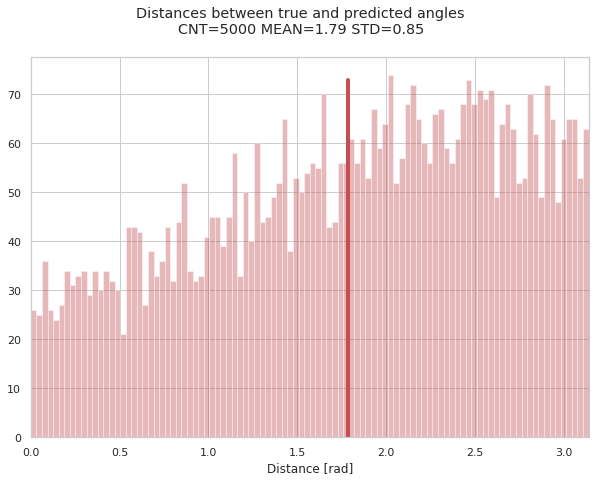

In [13]:
apt = rotate_by_something([tf.Variable([0.0, 0.0, 0.0], dtype=tf.float64)], angles_true)
plot_distances_count(apt, angles_true);

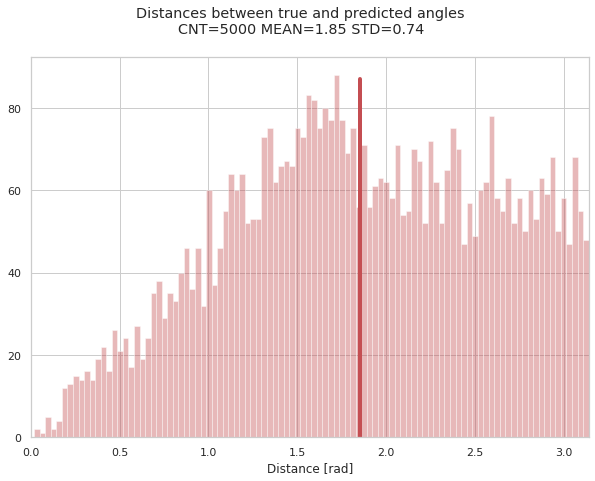

In [14]:
# rotate first angle by pi
apt = rotate_by_something([tf.Variable([np.pi, 0.0, 0.0], dtype=tf.float64)], angles_true)
plot_distances_count(apt, angles_true);

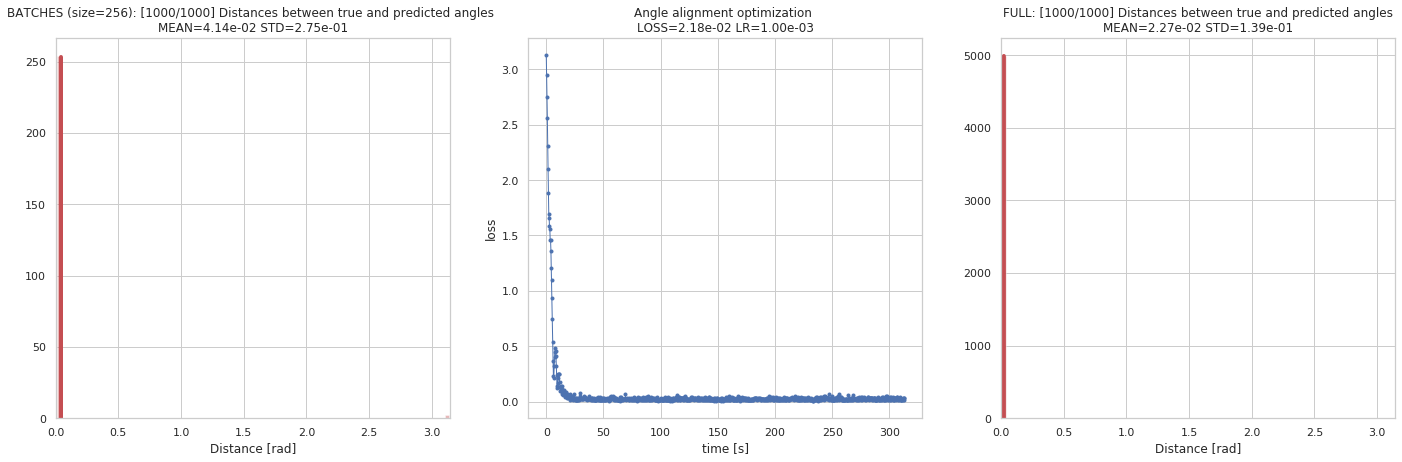

step 100/1000 (32s): loss = 4.21e-01
step 200/1000 (62s): loss = 2.47e-02
step 300/1000 (93s): loss = 2.41e-02
step 400/1000 (125s): loss = 2.32e-02
step 500/1000 (157s): loss = 2.27e-02
step 600/1000 (189s): loss = 2.37e-02
step 700/1000 (221s): loss = 2.48e-02
step 800/1000 (254s): loss = 2.51e-02
step 900/1000 (285s): loss = 2.48e-02
step 1000/1000 (316s): loss = 2.55e-02



In [13]:
m, rotation, loss = training_angle_alignment(m=1.0,
                         steps=1000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.1, 
                         angles_true=angles_true, 
                         angles_predicted=apt)

In [15]:
m, rotation[0].numpy(), loss

(1.0, array([ 1.5644009e+00, -8.7898746e-03, -7.7314628e-04, -3.2300614e-03,
         6.1416868e-03,  1.5730746e+00], dtype=float32), 0.025690597137860358)

Mean `quaternion` distance between true and predicted values: 0.023 rad (1.301 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.023 rad (1.301 degrees)


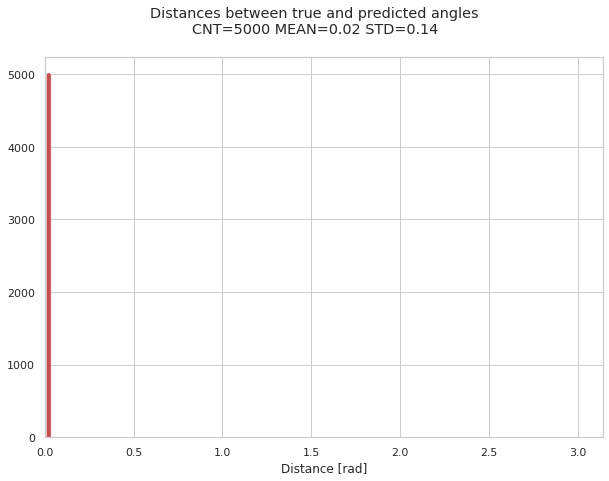

In [18]:
# trying to recover when the 1st angle is rotated by pi (10K steps)
mat = update_angles(m, rotation, apt)
distance_difference(angles_predicted=mat, angles_true=angles_true);
plot_distances_count(mat, angles_true);

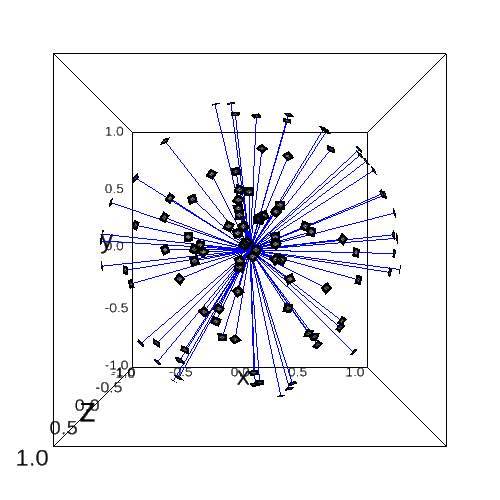

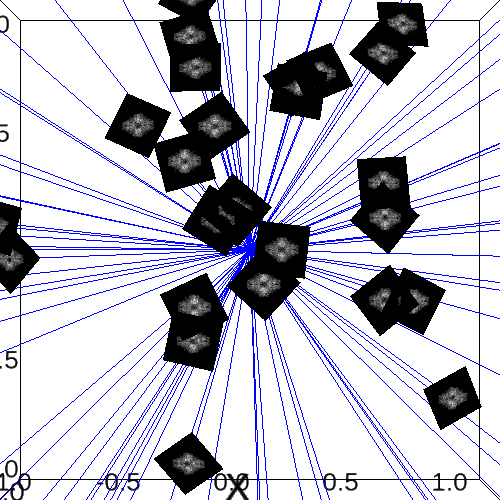

In [19]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [21]:
display(ipv.screenshot())

Output()

---

In [16]:
apt

<tf.Tensor: id=1944, shape=(5000, 3), dtype=float64, numpy=
array([[-2.34039046,  0.84906729,  0.40029977],
       [ 2.58562485,  0.52439503,  3.08960278],
       [ 1.87740968,  0.17657386, -1.87796181],
       ...,
       [-2.59952109,  1.07968313, -2.24867984],
       [ 0.8855796 ,  0.65006988,  1.96971234],
       [ 0.76904855,  0.82837041,  0.5964957 ]])>

In [17]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

Mean `quaternion` distance between true and predicted values: 0.000 rad (0.000 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.000 rad (0.000 degrees)


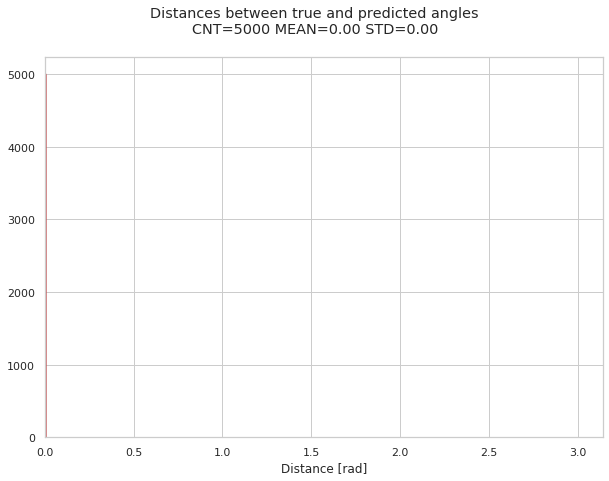

In [24]:
apt = update_angles(1.0, [tf.Variable([0.0,0.0,0.0,0.0,0.0,0.0])], angles_true, transposed=True)
distance_difference(angles_predicted=apt, angles_true=angles_true);
plot_distances_count(apt, angles_true);

Mean `quaternion` distance between true and predicted values: 0.592 rad (33.890 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.592 rad (33.890 degrees)


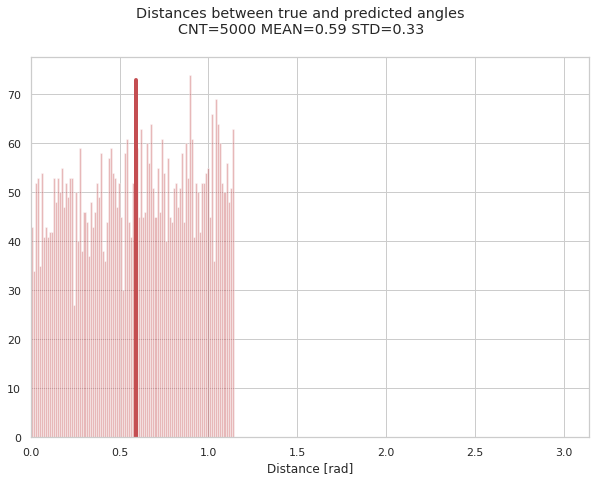

In [25]:
apt = update_angles(1.0, [tf.Variable([1.0,0.0,0.0,0.0,0.0,0.0])], angles_true, transposed=True)
distance_difference(angles_predicted=apt, angles_true=angles_true);
plot_distances_count(apt, angles_true);

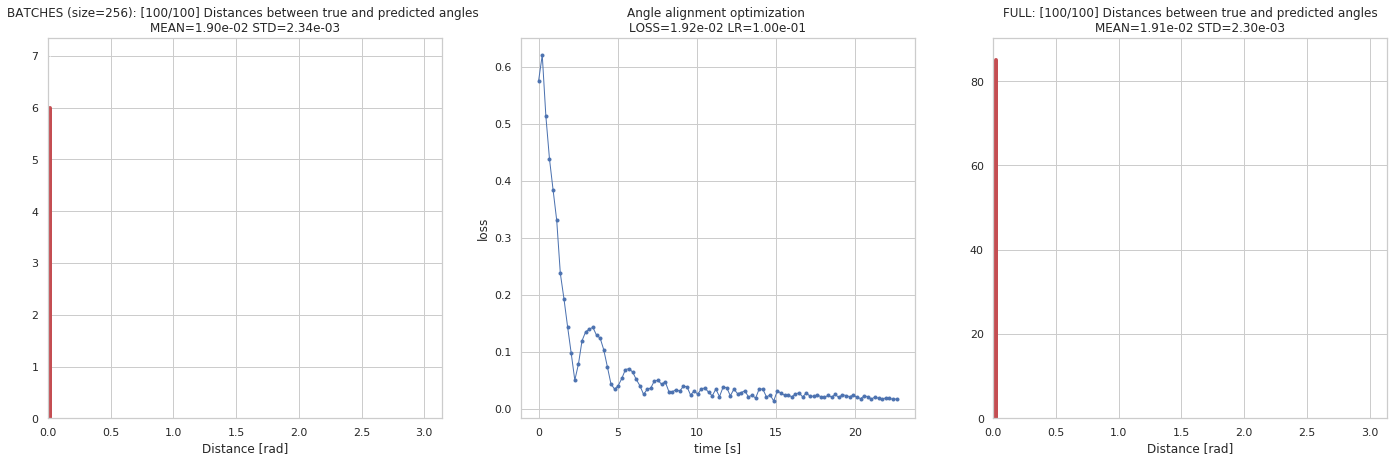

step 10/100 (2s): loss = 3.82e-01
step 20/100 (5s): loss = 1.14e-01
step 30/100 (7s): loss = 5.22e-02
step 40/100 (10s): loss = 3.96e-02
step 50/100 (12s): loss = 3.18e-02
step 60/100 (14s): loss = 2.94e-02
step 70/100 (17s): loss = 2.59e-02
step 80/100 (19s): loss = 2.41e-02
step 90/100 (22s): loss = 2.29e-02
step 100/100 (25s): loss = 1.93e-02



In [27]:
m, rotation, loss = training_angle_alignment(m=1.0,
                         steps=100, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.1, 
                         angles_true=angles_true, 
                         angles_predicted=apt)

In [28]:
m, rotation[0].numpy(), loss

(1.0, array([-0.99427915,  0.00685248, -0.00345872, -0.00363764, -0.00978376,
         0.00237894], dtype=float32), 0.019230812795127807)

Mean `quaternion` distance between true and predicted values: 0.025 rad (1.419 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.025 rad (1.419 degrees)


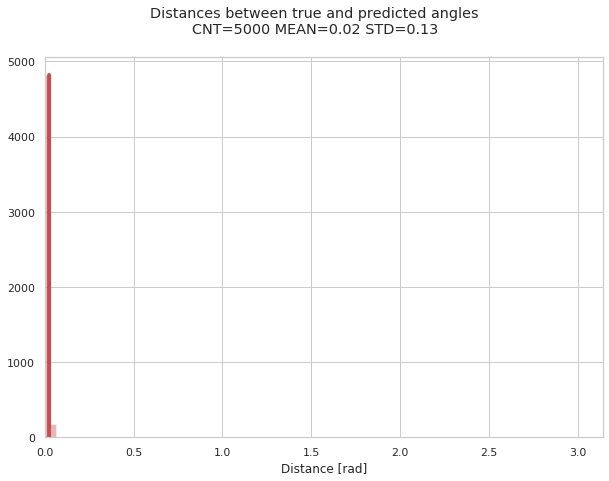

In [29]:
# trying to recover when the 1st angle is rotated by pi (10K steps)
mat = update_angles(m, rotation, apt)
distance_difference(angles_predicted=mat, angles_true=angles_true);
plot_distances_count(mat, angles_true);

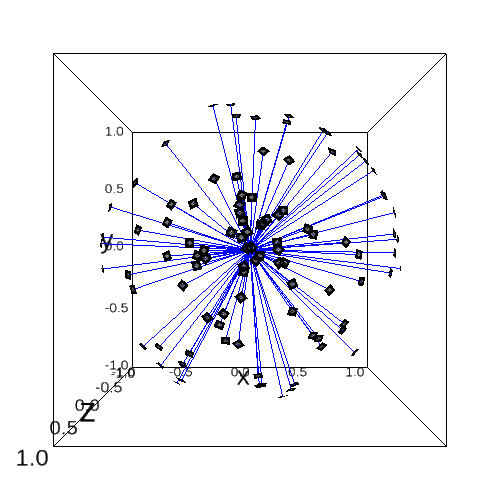

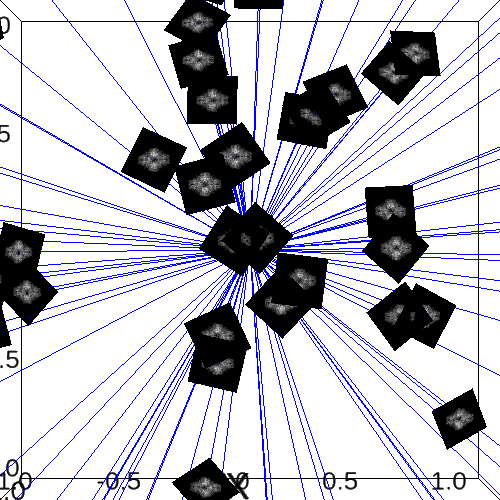

In [30]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [32]:
display(ipv.screenshot())

Output()

---